In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import ast
import re
from datetime import datetime

## Let's extract all logs from a file with level below DEBUG

In [2]:
with open('bot_logs.log', 'r', encoding='utf-8-sig') as file:
    lines = file.read()

In [3]:
timestamps = []
levels = []
messages = []

pattern = re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<level>\w+) - (?P<message>.+)')

for line in lines.strip().split('\n'):
    match = pattern.match(line)
    if match:
        timestamps.append(datetime.strptime(match.group('timestamp'), '%Y-%m-%d %H:%M:%S,%f'))
        levels.append(match.group('level'))
        messages.append(match.group('message'))

In [4]:
history_logs = {'date': [], 'time': [], 'level': [], 'user_id': [], 'info': [], 'step': []}

for idx, el in enumerate(messages):
    if levels[idx] != 'DEBUG':
        history_logs['date'].append(timestamps[idx].date())
        history_logs['time'].append(timestamps[idx].time())
        history_logs['level'].append(levels[idx])

        info = ast.literal_eval(messages[idx])
        history_logs['user_id'].append(info['user_id'])
        history_logs['info'].append(info['info'])
        history_logs['step'].append(info['step'])

In [5]:
logs_df = pd.DataFrame.from_dict(history_logs)

## Let's present the data as a graph
* `Green` is the start vertex
* `Red` is the end vertex

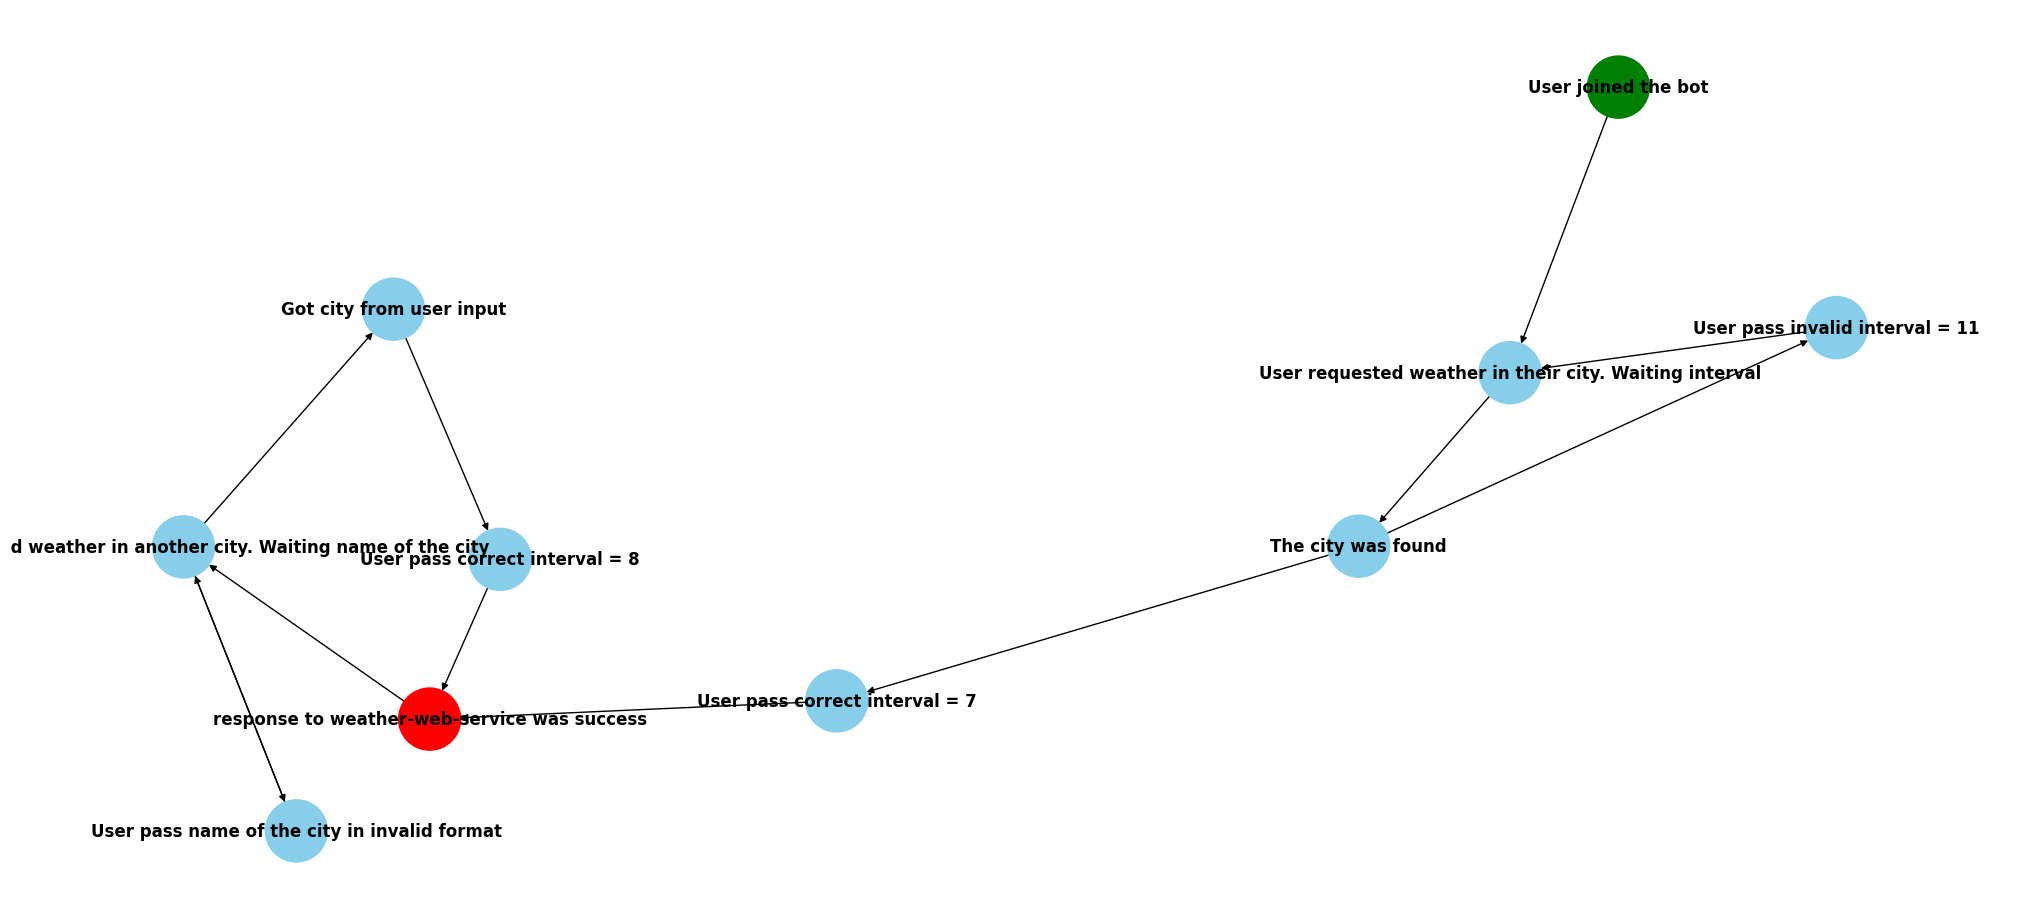

In [8]:
G = nx.DiGraph()

for i, entry in logs_df.iterrows():
    step = entry["info"]
    G.add_node(step)

    if i > 0:
        G.add_edge(logs_df.iloc[i - 1]["info"], step)

node_colors = ['green' if node == logs_df.iloc[0]["info"] else 'red' if node == logs_df.iloc[-1]["info"] else 'skyblue' for node in G.nodes]

plt.figure(figsize=(20, 9))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=2000)
plt.show()

## Выводы по графу 
Видно, что на графе заметны два выраженных цикла, пользователю приходится повторять заново операция запроса погоды, после ввода неверного ввода интервала кол-ва дней. Можем цепочку `запрос_погоды->запрос_интервала->ошибочный_интервал->запрос_погоды` сократить до `запрос_погоды->запрос_интервала->ошбичный_интервал->запрос_интервала_снова` 

## Let's find the chain of actions that caused the error
* `Green` is the start vertex
* `Red` is the `ERROR` vertex

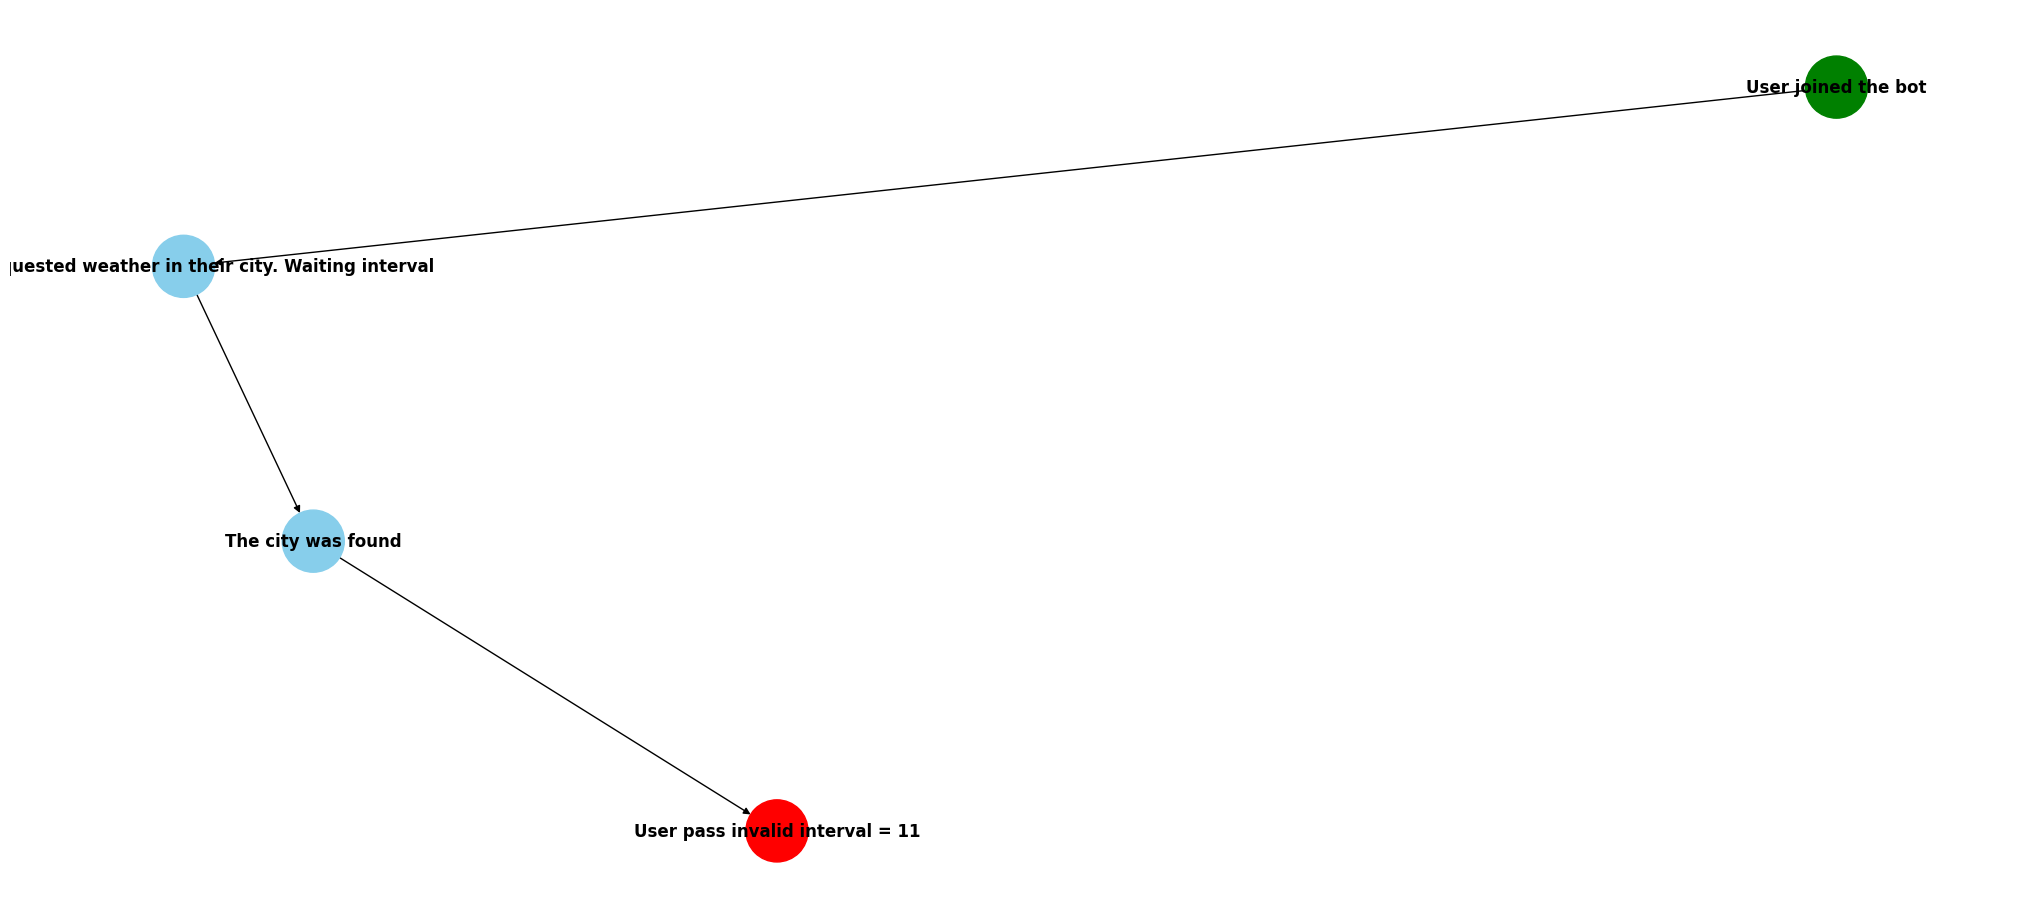

In [9]:
G = nx.DiGraph()

last_idx = -1

for i, entry in logs_df.iterrows():
    step = entry["info"]
    level = entry['level']
    G.add_node(step)

    if i > 0:
        G.add_edge(logs_df.iloc[i - 1]["info"], step)
    if level == 'ERROR':
        last_idx = i
        break

node_colors = ['green' if node == logs_df.iloc[0]["info"] else 'red' if node == logs_df.iloc[last_idx]["info"] else 'skyblue' for node in G.nodes]

plt.figure(figsize=(20, 9))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=2000)
plt.show()

## Let's find the longest way
Основная идея в том, что мы будем запускать dfs из каждой из вершин исходящих из `User joined the bot` и найдем самый длинный путь от вхождения в бота до отправки погоды.

In [87]:
G = nx.DiGraph()

for i, entry in logs_df.iterrows():
    step = entry["info"]
    G.add_node(step)

    if i > 0:
        G.add_edge(logs_df.iloc[i - 1]["info"], step)
source = 'User joined the bot'
end = 'response to weather-web-service was success'


## remove vertex - 'response to weather-web-service was success'
graph_copy = G.copy()
graph_copy.remove_node(end)
subgraphs = list(nx.weakly_connected_components(graph_copy))
subgraphs = [x for x in subgraphs if source in x]

## Remove first vertex 'User joined the bot'
graph_copy.remove_node(source)
subgraphs = list(nx.weakly_connected_components(graph_copy))
largest_subgraph_nodes = max(subgraphs, key=len)
largest_subgraph_nodes

{'The city was found',
 'User pass correct interval = 7',
 'User pass invalid interval = 11',
 'User requested weather in their city. Waiting interval'}

На визуализации получили самый длинный подграф, который начинается от `User joined the bot` до `response to weather-web-service was success`(Эти вершины не отображаются на графике)

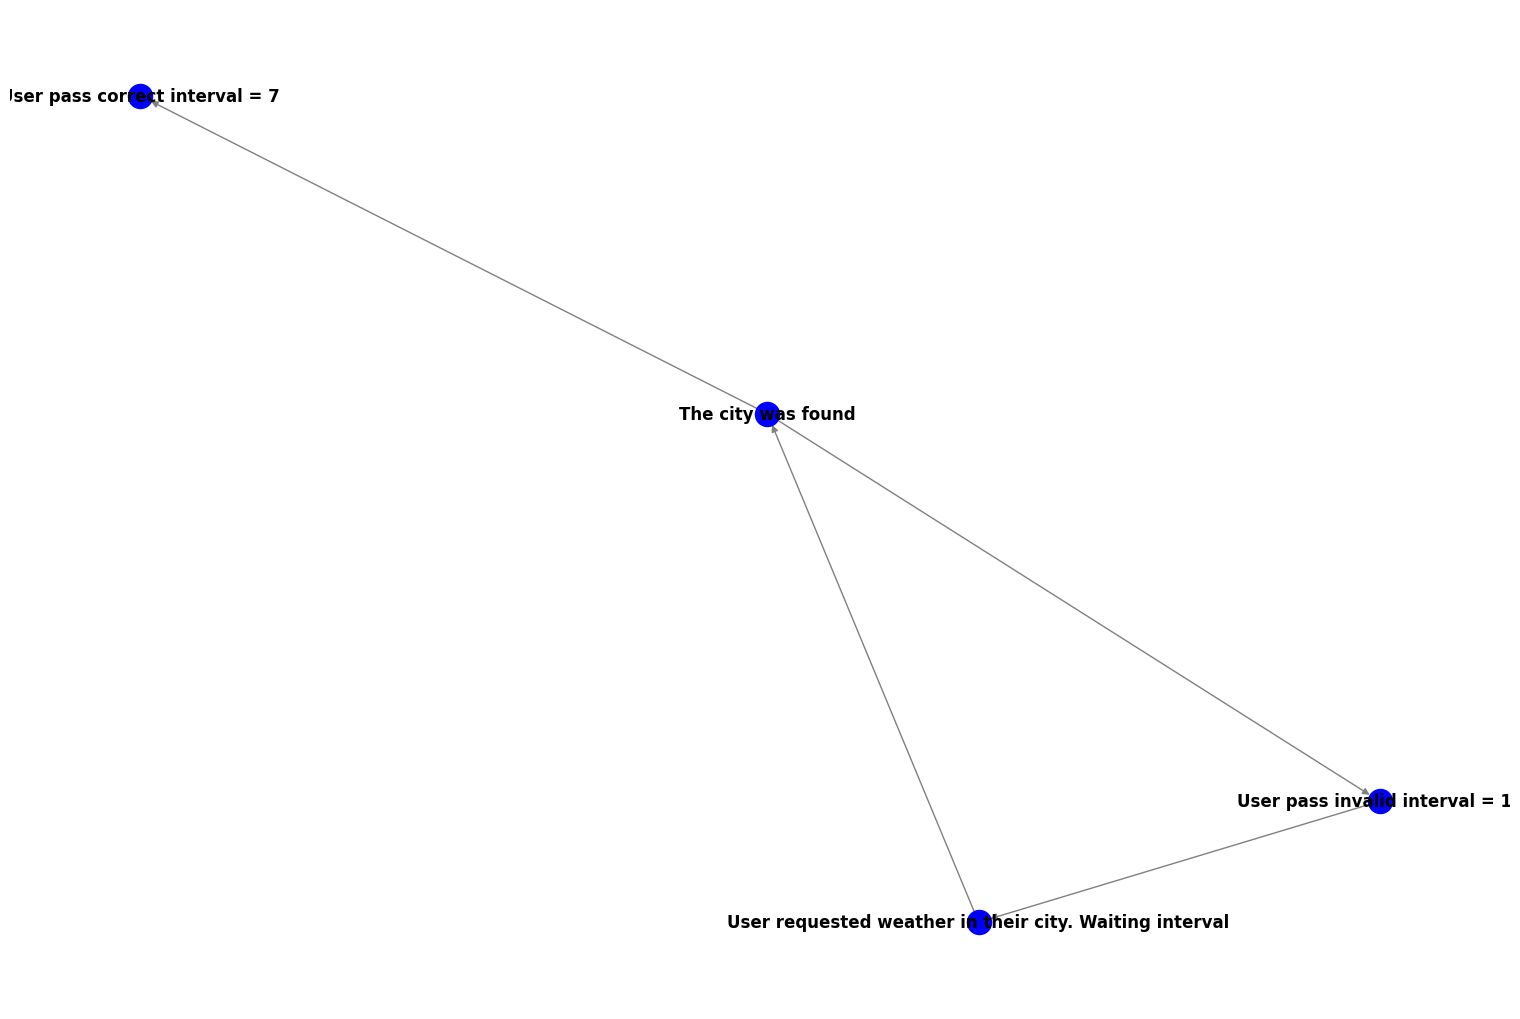

In [96]:
pos = nx.spring_layout(G)

subgraph = G.subgraph(largest_subgraph_nodes)
plt.figure(figsize=(15, 10))
nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_color=f"blue", edge_color=f"grey")
plt.show()